# Advanced Natural Language Processing

## Baseline model - N-Gram



In [1]:
# Uncomment this line when using Google Colab

#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# General useful tools
import numpy as np
import pandas as pd
import os, random, math, csv, collections, nltk, operator

#Visualization tools
import seaborn as sns
import matplotlib.pyplot as plt

# NLP tools
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Joakim
[nltk_data]     Torsvik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Importing the training-, and testing data

The language model will be trained on the Project Gutenberg corpus, with the Sherlock Holmes novels, written by Sir Arthur Conan Doyle.

In [3]:
# Google Colab directory path

#parentdir = "/content/drive/MyDrive/sentence-completion"
#trainingdir = parentdir + "/Holmes_Training_Data"
#questions = os.path.join(parentdir,"testing_data.csv")
#answers = os.path.join(parentdir,"test_answer.csv")

In [4]:
# Jupyter Notebook directory path

parentdir = "C:\\Users\Joakim Torsvik\Downloads\MSc Data Science\Advanced NLP\Week 2 - N-grams\sentence-completion"
trainingdir = parentdir + "/Holmes_Training_Data"
questions = os.path.join(parentdir, "testing_data.csv")
answers = os.path.join(parentdir, "test_answer.csv")

In [5]:
with open(questions) as instream:
    csvreader = csv.reader(instream)
    lines = list(csvreader)
qs_df = pd.DataFrame(lines[1:], columns=lines[0])
qs_df.head()

,id,question,a),b),c),d),e)
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus


In [6]:
with open(answers) as instream:
    csvreader = csv.reader(instream)
    lines = list(csvreader)
ans_df = pd.DataFrame(lines[1:], columns=lines[0])
ans_df.head()

,id,answer
0,1,c
1,2,a
2,3,d
3,4,c
4,5,d


## Making the n-gram language model

This language model will predict the words from the questions with use of a **Unigram**, **Bigram**, and **Trigram**. 

The model was first developed in the *Advanced Natural Language Processing* module at the University of Sussex, then redeveloped by me to include a trigram model.

In [89]:
def get_training_testing(training_dir=trainingdir, split=0.5):

    filenames = os.listdir(training_dir)
    n = len(filenames)
    print(f"There are {n} files in the training directory: {training_dir}")
    random.seed(64) 
    random.shuffle(filenames)
    index = int(n*split)
    trainingfiles=filenames[:index]
    heldoutfiles=filenames[index:]
    
    return trainingfiles, heldoutfiles


class language_model():
    
    
    """ This LM can train and predict words using a unigram, bigram or trigram.
    The n-grams are smoothed with Absolute Discounting, Kneser-Ney and a OOV threshold."""
    
    
    def __init__(self, known=2, discount=0.75, trainingdir=trainingdir, files=[]):
        self.training_dir = trainingdir
        self.files = files
        self.discount = discount
        self.known = known
        self.train()
        
    def train(self):
        self.unigram = {}
        self.bigram = {}
        self.trigram = {}
        self.count_token = {}

        self._processfiles()
        self._make_unknowns()
        self._kneser_ney()
        self._convert_to_probs()
      
    
    def _processline(self,line):
        tokens = ["__START"] + word_tokenize(line) + ["__END"]
        previous = "__END"
        prev_tri = ["__END", "__END"]
        for token in tokens:
            # Unigram Frequency distribution (+ vocab_size)
            self.unigram[token] = self.unigram.get(token,0) + 1

            # Count tokens
            self.count_token[token] = self.count_token.get(token,0) + 1
              
            # Bigram Frequency Distribution
            current = self.bigram.get(previous,{})
            current[token] = current.get(token,0) + 1
            self.bigram[previous] = current

            # Trigram Frequency Distribution
            prev_tri[1], prev_tri[0] = prev_tri[0], prev_tri[1]
            prev_tri[1] = previous
            current = self.trigram.get(tuple(prev_tri), {})
            current[token] = current.get(token, 0) + 1
            self.trigram[tuple(prev_tri)] = current

            previous = token
    
    def _processfiles(self):
        
        for afile in self.files:
            try:
                with open(os.path.join(self.training_dir, afile)) as instream:
                    for line in instream:
                        line = line.rstrip()
                        if len(line) > 0:
                            self._processline(line)
            except UnicodeDecodeError:
                print(f"UnicodeDecodeError processing {afile}: ignoring rest of file")
      
              
    def _convert_to_probs(self):
          
        self.unigram = {k:v/sum(self.unigram.values()) for (k,v) in self.unigram.items()}
        self.bigram = {key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.bigram.items()}
        self.trigram = {key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.trigram.items()}
        self.bi_kn = {k:v/sum(self.bi_kn.values()) for (k,v) in self.bi_kn.items()}
        self.tri_kn = {k:v/sum(self.tri_kn.values()) for (k,v) in self.tri_kn.items()}
        
        
    def get_prob(self, token, context="", methodparams={}):
        if methodparams.get("method", "unigram") == "unigram":
            return self.unigram.get(token, self.unigram.get("__UNK", 0))
          
        elif methodparams.get("method", "bigram") == "bigram": 
            if methodparams.get("smoothing", "kneser-ney") == "kneser-ney":
                unidist = self.bi_kn
            else:
                unidist = self.unigram

            bigram = self.bigram.get(context[-1], self.bigram.get("__UNK",{}))
            bi_p = bigram.get(token,bigram.get("__UNK",0))
            lmbda = bigram["__DISCOUNT"]
            uni_p = unidist.get(token,unidist.get("__UNK",0))
            p = bi_p + lmbda * uni_p            
            return p

        elif methodparams.get("method", "trigram") == "trigram":
            if methodparams.get("smoothing", "kneser-ney") == "kneser-ney":
                unidist = self.tri_kn
                unidist_bi = self.bi_kn
            else:
                unidist_bi = self.unigram

            if len(context) < 2:
                context = ["__END", context[0]]
            trigram = self.trigram.get(tuple(context[-2:]), self.trigram.get("__UNK", {}))
            tri_p = trigram.get(token, trigram.get("__UNK", 0))
            lmbda_tri = trigram["__DISCOUNT"]

            bigram = self.bigram.get(context[-1], self.bigram.get("__UNK", {}))
            bi_p = bigram.get(token, bigram.get("__UNK", 0))
            lmbda_bi = bigram["__DISCOUNT"]
            uni_p = unidist_bi.get(token, unidist_bi.get("__UNK", 0))

            p = tri_p + (lmbda_tri * bi_p) + (lmbda_bi * uni_p)      
            return p
      
    def compute_prob_line(self, line, methodparams={}):

        """Computes the probability of each line of the document"""
        
        tokens = ["__START"] + word_tokenize(line) + ["__END"]
        acc = 0
        for i, token in enumerate(tokens[1:]):
            acc += math.log(self.get_prob(token, tokens[:i+1], methodparams))
        return acc, len(tokens[1:])
      
    def compute_probability(self, filenames=[], methodparams={}):
        # computes the probability (and length) of a corpus contained in filenames
        if filenames == []:
            filenames = self.files
      
        total_p = 0
        total_N = 0
        for i, afile in enumerate(filenames):
            try:
                with open(os.path.join(self.training_dir, afile)) as instream:
                    for line in instream:
                        line = line.rstrip()
                        if len(line) > 0:
                            p,N = self.compute_prob_line(line, methodparams=methodparams)
                            total_p += p
                            total_N += N
            except UnicodeDecodeError:
                print(f"UnicodeDecodeError processing file {afile}: ignoring rest of file")
        return total_p, total_N
      
    def compute_perplexity(self, filenames=[], methodparams={"method":"bigram","smoothing":"kneser-ney"}):
        
        """Perplexity is a measurement of how well a probability 
        distribution or probability model predicts a sample. A low 
        perplexity indicates the probability distribution is good 
        at predicting the sample"""
        
        if methodparams.get("method") in ['unigram', 'bigram']:
            p, N = self.compute_probability(filenames=filenames, methodparams=methodparams)
            pp = math.exp(-p/N)
    
      
    def _make_unknowns(self):
        
        """Removing words below a threshold frequency and
        moving their values into a unknown sequence ("_UNK")."""
        
        # Unigram
        unknown = 0
        self.number_unknowns = 0
        for (k,v) in list(self.unigram.items()):
            if v < self.known:
                del self.unigram[k]
                self.unigram["__UNK"] = self.unigram.get("__UNK",0) + v
                self.number_unknowns += 1
        # Bigram
        for (k,adict) in list(self.bigram.items()):
            for (kk,v) in list(adict.items()):
                isknown = self.unigram.get(kk,0)
                if isknown == 0 and not kk == "__DISCOUNT":
                    adict["__UNK"] = adict.get("__UNK",0) + v
                    del adict[kk]
            isknown = self.unigram.get(k,0)
            if isknown == 0:
                del self.bigram[k]
                current = self.bigram.get("__UNK",{})
                current.update(adict)
                self.bigram["__UNK"] = current
            else:
                self.bigram[k] = adict
        # Trigram
        for (k,adict) in list(self.trigram.items()):
            for (kk,v) in list(adict.items()):
                isknown = self.unigram.get(kk,0)
                if isknown == 0 and not kk == "__DISCOUNT":
                    adict["__UNK"] = adict.get("__UNK",0) + v
                    del adict[kk]
            prev_1, prev_2 = k
            isknown_1, isknown_2 = self.unigram.get(prev_1,0), self.unigram.get(prev_2,0)
            if isknown_1 == 0 or isknown_2 == 0:
                del self.trigram[k]
                current = self.trigram.get("__UNK",{})
                current.update(adict)
                self.trigram["__UNK"] = current
            else:
                self.trigram[k] = adict
            
                  
    def _kneser_ney(self):


        self.bigram = {k:{kk:value-self.discount for (kk,value) in adict.items()} for (k,adict) in self.bigram.items()}
        self.trigram = {k:{kk:value-self.discount for (kk,value) in adict.items()} for (k,adict) in self.trigram.items()}
          
        # For each word, store the total amount of the discount so that the total is the same 
        # i.e., so we are reserving this as probability mass
        for k in self.bigram.keys():
            lamb = len(self.bigram[k])
            self.bigram[k]["__DISCOUNT"] = lamb * self.discount
                  
        for k in self.trigram.keys():
            lamb = len(self.trigram[k])
            self.trigram[k]["__DISCOUNT"] = lamb * self.discount

        # Work out kneser-ney unigram probabilities
        # Count the number of contexts each word has been seen in
        self.bi_kn = {}
        for (k,adict) in self.bigram.items():
            for kk in adict.keys():
                self.bi_kn[kk] = self.bi_kn.get(kk,0) + 1

        self.tri_kn = {}
        for (k,adict) in self.trigram.items():
            for kk in adict.keys():
                self.tri_kn[kk] = self.tri_kn.get(kk,0) + 1

In [80]:
class question:
    
    def __init__(self, aline):
        self.fields = aline
    
    def get_field(self, field):
        return self.fields[question.colnames[field]]
    
    def add_answer(self, fields):
        self.answer = fields[1]

    def get_tokens(self):
        return ["__START"] + word_tokenize(self.fields[question.colnames["question"]]) + ["__END"]

    def get_left_context(self, window=1, target="_____"):
        found = -1
        sent_tokens = self.get_tokens()
        for i, token in enumerate(sent_tokens):
            if token == target:
                found = i
                break  
        if found >- 1:
            return sent_tokens[i-window:i]
        else:
            return []

    def get_right_context(self, window=1, target="_____"):
        found = -1
        sent_tokens = self.get_tokens()
        for i,token in enumerate(sent_tokens):
            if token == target:
                found = i
                break
        if found >- 1:
            return sent_tokens[found + 1:found + window + 1]  
        else:
            return []

    def choose(self, lm, method="bigram", smoothing="Kneser-ney", choices=[]):
        
        """ Chooses the specific n-gram model to get 
        the predicted answer from the alternatives."""
        
        if choices == []:
            choices = ["a", "b", "c", "d", "e"]

        if method == "bigram":
            rc = self.get_right_context(window=1)
            lc = self.get_left_context(window=1)
            probs = [lm.get_prob(rc[0],[self.get_field(ch+")")],
                                 methodparams={"method":method.split("_")[0], "smoothing":smoothing}) 
                    * lm.get_prob(self.get_field(ch+")"),lc,
                                  methodparams={"method":method.split("_")[0], "smoothing":smoothing}) for ch in choices]

        elif method == "trigram":
            rc = self.get_right_context(window=2)
            lc = self.get_left_context(window=2)
            probs = [lm.get_prob(self.get_field(ch+")"), lc, 
                                 methodparams={"method":method.split("_")[0], "smoothing":smoothing})
                    * lm.get_prob(rc[0], [lc[-1]] + [self.get_field(ch+")")],
                                  methodparams={"method":method.split("_")[0], "smoothing":smoothing})
                    * lm.get_prob(rc[1], [self.get_field(ch+")")] + [rc[0]],
                                  methodparams={"method":method.split("_")[0], "smoothing":smoothing}) for ch in choices]
        
        else:
            context = self.get_left_context(window=1)
            probs = [lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":method.split("_")[0]}) for ch in choices]
        
        maxprob = max(probs)
        bestchoices = [ch for ch,prob in zip(choices,probs) if prob == maxprob]

        return np.random.choice(bestchoices), probs
      
    def predict(self,lm,method="bigram", smoothing="kneser-ney"):
        
        
        return self.choose(lm, method=method, smoothing=smoothing, choices=[])

    def predict_and_score(self,lm,method="bigram", smoothing="kneser-ney"):
        
        """Runs the n-gram LM and returns:
        1 if the predicted answer is correct
        0 if the predicted answer is incorrect"""
        
        prediction, probs = self.predict(lm,method=method,smoothing=smoothing)

        if prediction == self.answer:
            return 1, prediction, probs
        else:
            return 0, prediction, probs

class scc_reader:
      
    def __init__(self,qs,ans):
        self.qs=qs
        self.ans=ans
        self.read_files()
      
    def read_files(self):
        
        #read in the question file
        with open(self.qs) as instream:
            csvreader = csv.reader(instream)
            qlines = list(csvreader)
      
        #store the column names as a reverse index so they can be used to reference parts of the question
        question.colnames = {item:i for i,item in enumerate(qlines[0])}
        
        #create a question instance for each line of the file (other than heading line)
        self.questions = [question(qline) for qline in qlines[1:]]
        
        #read in the answer file
        with open(self.ans) as instream:
            csvreader = csv.reader(instream)
            alines = list(csvreader)
            
        #add answers to questions so predictions can be checked    
        for q,aline in zip(self.questions,alines[1:]):
            q.add_answer(aline)
        
    def get_field(self,field):
        return [q.get_field(field) for q in self.questions] 
    
    def predict(self,method="bigram"):
        return [q.predict(method=method) for q in self.questions]
    
    def predict_and_score(self,lm,method="bigram",smoothing="kneser-ney"):
        """
        Return the accuracy of the ngram, along with all its predictions and the 
        probability distribution of the options of each question
        """
        predictions = []
        scores = []
        total_probs = []
        for q in self.questions:
            score, pred, probs = q.predict_and_score(lm,method=method, smoothing=smoothing)
            scores.append(score)
            predictions.append(pred)
            total_probs.append(probs)

        return sum(scores)/len(scores), predictions, total_probs

## Analysis


### Hyperparamater tuning

In [9]:
file_path = os.listdir(trainingdir)
n_files = [10, 50, 100]
threshold = [2, 5, 10]
discount = [0.5, 0.75, 1.00]
MAX_FILES = 2
results = []
predictions = []
ngram_probs = []

iter = 0
for n in n_files:
    for i in threshold:
        for d in discount:
            print(f"Training lm on {n} documents.")
            mylm = language_model(known=i, discount=d, files=file_path[:n])
            SCC = scc_reader(questions, answers)
            unigram_acc, unigram_pred, unigram_probs = SCC.predict_and_score(mylm, method="unigram", smoothing='kneser-ney')
            bigram_acc, bigram_pred, bigram_probs = SCC.predict_and_score(mylm, method="bigram", smoothing='kneser-ney')
            trigram_acc, trigram_pred, trigram_probs = SCC.predict_and_score(mylm, method="trigram", smoothing='kneser-ney')

            results.append((n, i, d, round(unigram_acc * 100, 3), round(bigram_acc * 100, 3), round(trigram_acc * 100, 3)))
            predictions.append((unigram_pred, bigram_pred, trigram_pred))
            ngram_probs.append((unigram_probs, bigram_probs, trigram_probs))
            iter += 1

Training lm on 10 documents.
Training lm on 10 documents.
Training lm on 10 documents.
Training lm on 10 documents.
Training lm on 10 documents.
Training lm on 10 documents.
Training lm on 10 documents.
Training lm on 10 documents.
Training lm on 10 documents.
Training lm on 50 documents.
Training lm on 50 documents.
Training lm on 50 documents.
Training lm on 50 documents.
Training lm on 50 documents.
Training lm on 50 documents.
Training lm on 50 documents.
Training lm on 50 documents.
Training lm on 50 documents.
Training lm on 100 documents.
Training lm on 100 documents.
Training lm on 100 documents.
Training lm on 100 documents.
Training lm on 100 documents.
Training lm on 100 documents.
Training lm on 100 documents.
Training lm on 100 documents.
Training lm on 100 documents.


### Table 1
The table displays how the accuracy is affected by changes in three hyper-parameters:
 - The number of files used to train the model on (n_files)
 - The lower threshold of words to be removed from the vocabulary (OOV_Threshold)
 - A discount to remove from the frequency of every word in the vocabulary (Discount)

In [10]:
df = pd.DataFrame(results, columns=['n_files', 'OOV_Threshold', 'Discount', 'Unigram_Acc', 'Bigram_Acc', 'Trigram_Acc'])
display(df)

,n_files,OOV_Threshold,Discount,Unigram_Acc,Bigram_Acc,Trigram_Acc
0,10,2,0.50,20.865,19.808,21.442
1,10,2,0.75,20.962,19.327,20.673
2,10,2,1.00,21.154,19.423,20.192
3,10,5,0.50,17.308,18.077,22.212
4,10,5,0.75,15.865,18.558,21.731
5,10,5,1.00,16.635,19.135,19.712
6,10,10,0.50,17.404,21.058,21.923
7,10,10,0.75,15.769,19.904,21.923
8,10,10,1.00,14.423,18.750,17.308
9,50,2,0.50,24.135,20.000,25.865


After tuning the hyperparameters for each model, let's see what how high the accuracy of each n-gram is:

In [11]:
mylm = language_model(known=2, discount=0.75, files=file_path)
unigram_acc, unigram_pred, unigram_probs = SCC.predict_and_score(mylm, method="unigram", smoothing='kneser-ney')
bigram_acc, bigram_pred, bigram_probs = SCC.predict_and_score(mylm, method="bigram", smoothing='kneser-ney')
trigram_acc, trigram_pred, trigram_probs = SCC.predict_and_score(mylm, method="trigram", smoothing='kneser-ney')

res = [round(unigram_acc * 100, 3), round(bigram_acc * 100, 3), round(trigram_acc * 100, 3)]

### Table 2
The table shows each n-gram in the language model with their optimized hyper-parameter settings from table 1

C:\Users\Joakim Torsvik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Performance')

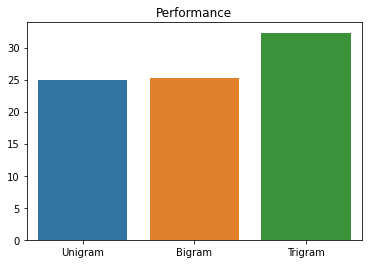

In [24]:
df = pd.DataFrame(res, index=["Unigram", "Bigram", "Trigram"]).transpose()
df.head()

sns.barplot(["Unigram", "Bigram", "Trigram"], res)
plt.title("Performance")

### Comparing the answers 

In [25]:
uni = []
bi = []
tri = []
for i in range(len(unigram_pred)):
    # Unigram
    if ans_df['answer'][i] == unigram_pred[i]:
        uni.append(1)
    else:
        uni.append(0) 
    # Bigram
    if ans_df['answer'][i] == bigram_pred[i]:
        bi.append(1)
    else:
        bi.append(0)
    # Trigram
    if ans_df['answer'][i] == trigram_pred[i]:
        tri.append(1)
    else:
        tri.append(0)

comparison = [(uni[i] + bi[i] + tri[i])/3 for i in range(len(uni))]
print(f"Number of questions where 3/3 models were correct: {sum([int(i) for i in comparison if i == 1])}")
print(f"Number of questions where 2/3 models were correct: {sum([1 for i in comparison if round(i,3) == 0.667])}")
print(f"Number of questions where 1/3 models were correct: {sum([1 for i in comparison if round(i,3) == 0.333])}")
print(f"Number of questions where 0/3 models were correct: {sum([1 for i in comparison if round(i,3) == 0])}")

Number of questions where 3/3 models were correct: 68
Number of questions where 2/3 models were correct: 184
Number of questions where 1/3 models were correct: 286
Number of questions where 0/3 models were correct: 502


570 questions were predicted similarly by all models

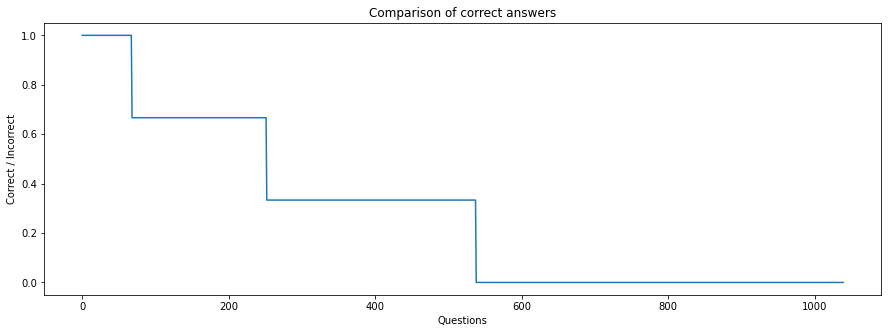

In [26]:
# If 1, all are correct.
# If 0.667, 2 / 3 are correct
# If 0.333, 1 / 3 is correct
# If 0, all models are wrong

plt.figure(figsize=(15, 5))
plt.plot(range(len(uni)), sorted(comparison, reverse=True))
plt.title("Comparison of correct answers")
plt.xlabel("Questions")
plt.ylabel("Correct / Incorrect")
plt.show()

## The Entropy and Perplexity of the n-grams

Entropy is defined as: $H(x) = - \sum{P(x_i) \times \log{P(x_i)}} $

Perplexity is defined as $H({\tilde  {p}},q)=-\sum _{x}{\tilde  {p}}(x)\log _{2}q(x) $

In [186]:
def entropy(probs, preds):
    ix = []
    for p in preds:
        if p == 'a':
            ix.append(0)
        elif p == 'b':
            ix.append(1)
        elif p == 'c':
            ix.append(2)
        elif p == 'd':
            ix.append(3)
        elif p == 'e':
            ix.append(4)
    
    return round(-sum([prob[ix[i]] * np.log2(prob[ix[i]]) for i, prob in enumerate(probs)]), 3)

In [182]:
df = pd.DataFrame([[entropy(unigram_probs, unigram_pred), 
                    entropy(bigram_probs, bigram_pred), 
                    entropy(trigram_probs, trigram_pred)],
                   [round(mylm.compute_perplexity(methodparams = {'method':'unigram', 'smoothing': 'kneser-ney'}), 3),
                    round(mylm.compute_perplexity(methodparams = {'method':'bigram', 'smoothing': 'kneser-ney'}), 3),
                    round(mylm.compute_perplexity(methodparams = {'method':'trigram', 'smoothing': 'kneser-ney'}), 3)],res],
                  columns=['Unigram', 'Bigram', 'Trigram'], index=['Entropy', 'Perplexity', 'Accuracy'])
df

,Unigram,Bigram,Trigram
Entropy,1.035,1.815,0.967
Perplexity,731.507,139.927,47.244
Accuracy,24.904,25.288,32.308
